## Python Notebook for analysis of $Science\ on\ a\ Stick$ data
This Notebook requires a folders containing time and voltage data from SOS apparatus

# The constants defined here: Read when computing the results:

### 1. Value of $t_i$
To calculate $t_i$, we know time starts collecting when magnet travels 3cm starting at $v = 0$, using laws of motion, we know that time travelled by 
$
\\ S = ut + \frac{1}{2at^2}
\\ u = 0, hence\ S = \frac{1}{2gt^2}
\\ \Rightarrow t = \sqrt{\frac{2S}{g}} =  \sqrt{\frac{2*6}{(9.8*100)}}\ seconds
\\ \Rightarrow t = 110.656 ms
$
### 2. $V_i$ the initial velocity at that time:
To find $ V_i $, we know magnet travelled for $ 110.656 \  ms $ from $ u = 0 $, hence by $ v = u + at $, $ V_i $ becomes 

$
\\ V_i = \frac{9.8 * 110.656}{1000}\ m/s = 1.084\ m/s
$

### 3. Position of the coil where we are comparing the plot.
Here, we will consider the centre of the coil as the point of comparison where we will plot velocity vs the upper peak of the voltage curve induced, ie the position varied is according to the starting end of the coil.
The zero crossing point, the centre of the coil is 2.5cm down of that same point which can be used to figure out the spreading factor for same. Hence when we say 16cm for example, the zero crossing is actually 16+2.5 = 18.5cm 
 
Hence everywhere, we will account for that extra 2.5cm and hence will map it accordingly on the calibration curve.

Run the Cells below substituting appropriate data for your setup

In [1]:
#import standard libraries
#use !pip install <library> if this cells return module not found error

import os

import numpy as np
import matplotlib.pyplot as plt
import mplcursors
import matplotlib.patches as mpatches

from scipy.optimize import curve_fit

In [2]:
# enter your directory path for the acquired data: 
# replace the below path with your csv location
#ensure atleast 3 readings at unique distance values

x_data_folder = "data/X"
y_data_folder = "data/Y"

xdata = []
ydata = []

distance = np.arange(.135, .335, .02)  #Array for the distances of coil at which readings are taken

for root, dirs, files in os.walk(x_data_folder, topdown=False):
    for name in files:
        if name[-3:] == 'csv':
            try:
                xdata.append(np.loadtxt(os.path.join(x_data_folder, name)))
                ydata.append(np.loadtxt(os.path.join(y_data_folder, name)))
            except FileNotFoundError:
                continue

if len(xdata) == 0:
    print("Incorrect data folder specified")

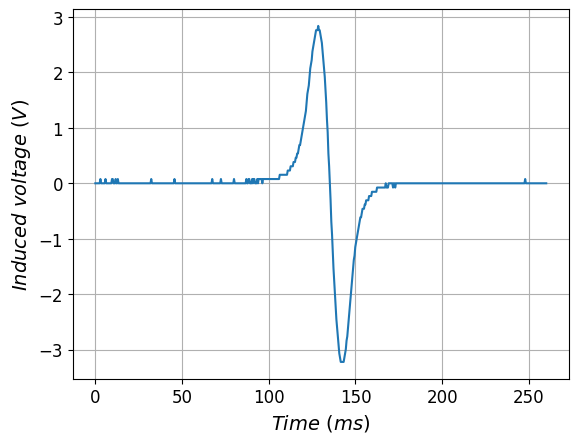

In [3]:
#Visualization of first data point

plt.grid(1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$\it{Time}$ $\it{(ms)}$', fontsize=14)
plt.ylabel('$\it{Induced}$ $\it{voltage}$ $\it{(V)}$', fontsize=14)
plt.plot(xdata[0], ydata[0], '-')
plt.show()

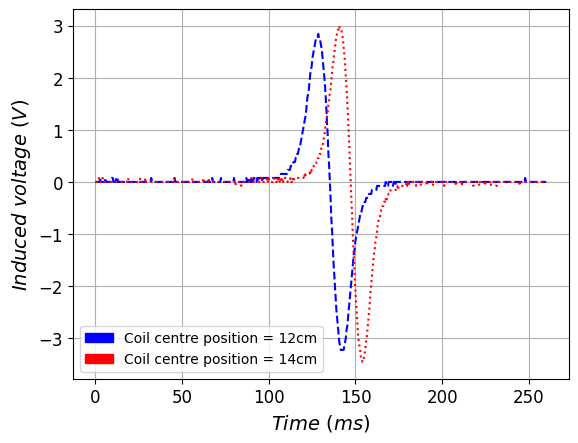

In [4]:
plt.grid(1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$\it{Time}$ $\it{(ms)}$', fontsize=14)
plt.ylabel('$\it{Induced}$ $\it{voltage}$ $\it{(V)}$', fontsize=14)
plt.plot(xdata[0], ydata[0], 'b--')
plt.plot(xdata[1], ydata[1], 'r', linestyle = 'dotted')

blue_patch = mpatches.Patch(color='blue', label='Coil centre position = 12cm')
red_patch = mpatches.Patch(color='red', label='Coil centre position = 14cm')
plt.legend(handles=[ blue_patch,red_patch])

plt.show()

---

### Equations of Motion verification

Read the zero crossing point for each of the location of coil 
As explained in paper, we multiply each of them by 1.08 and then calculate. 
Below are the standard corresponding values that we read: 

In [5]:
def find_zero_crossing(voltage, time):
    '''
    find zero crossing point for an SOS reading
    '''
    max_idx = voltage.argmax()
    min_idx = voltage.argmin()
    left, right = (max_idx, min_idx) if min_idx > max_idx else (min_idx, max_idx)
    zero_idx = np.argmin(np.abs(voltage[left:right]))

    return time[left + zero_idx]

time_centre = np.array([])
for time, voltage in zip(xdata, ydata):
    time_centre = np.append(time_centre, find_zero_crossing(voltage, time))

time_centre = np.array(time_centre) * 1.08
print('Time taken by Magnet to reach center of coil kept at different positions\n', time_centre)

Time taken by Magnet to reach center of coil kept at different positions
 [146.05217391 159.06533118 171.31284345 184.30615385 189.86188925
 201.48936585 214.35569132 222.28109855 234.42403846 239.50177706]


We want to plot $ distance $ $ vs $ $ time^2 $, hence let's square the above values after normalizing to seconds

In [6]:
time_centre_sq = (time_centre/1000) ** 2
print(time_centre_sq)

[0.02133124 0.02530178 0.02934809 0.03396876 0.03604754 0.04059796
 0.04594836 0.04940889 0.05495463 0.0573611 ]


In [7]:
print("Distance travelled by magnet", distance)

Distance travelled by magnet [0.135 0.155 0.175 0.195 0.215 0.235 0.255 0.275 0.295 0.315]


In [8]:
# First order curve fitting. We can also get closer points and improve accuracy:

def dist_v_time_2(time, u, g):
    return u + np.square(time)*g/2

(u, g), pcov = curve_fit(dist_v_time_2, time_centre/1000, distance)
std_err = np.sqrt(np.diag(pcov))


print(f"Estimated value of g: {g:.3f} ± {std_err[1]:.4f} m/s^2")
print(f"Estimated value of u: {u:.3f} ± {std_err[0]:.4f} m/s")

Estimated value of g: 9.776 ± 0.2096 m/s^2
Estimated value of u: 0.032 ± 0.0043 m/s


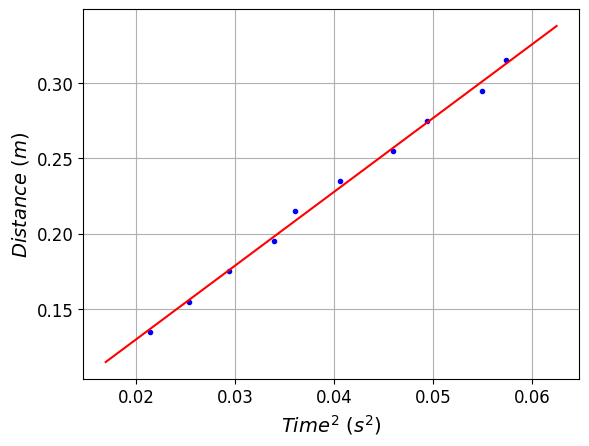

In [9]:
plt.grid(1)
plt.plot(time_centre_sq, distance, 'b.')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$Time^2$ $(s^2)$', fontsize=14)
plt.ylabel('$Distance$ $(m)$', fontsize=14)

#using the slope and intercept of the fit obtained to create the line:
x = np.linspace(.13, .25, num=15)
y = dist_v_time_2(x, u, g)
plt.plot(x**2,y,'r')
plt.show()

---

### Induced EMF with coil kept at multiple different points
Coil is kept at different distances to show variation is shape of curve obtained

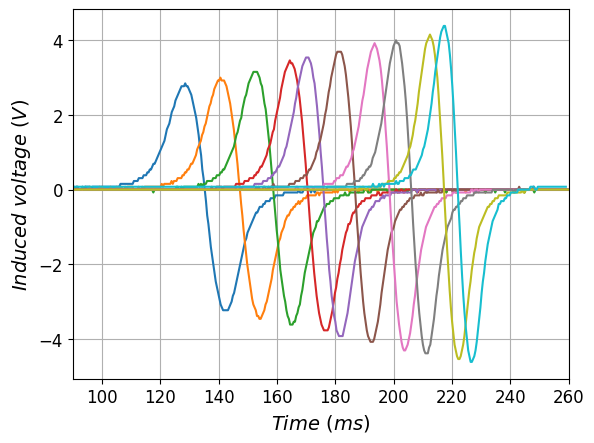

In [10]:
#Plot all 10 points together

plt.grid(1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$Time$ $(ms)$', fontsize=14)
plt.ylabel('$Induced$ $voltage$ $(V)$', fontsize=14)

for time, voltage in zip(xdata, ydata):
    plt.plot(time, voltage)

left, right = plt.xlim()
plt.xlim(left=90, right=260)

plt.show()

---

### $ EMF_{max}^2 $ vs position 

For each of the peak locations, read the upper point in an array and plot the square of emf vs position for the correspoding peak voltages

Using equation (as mentioned in the paper)

$
ε_{max} = ±\frac{24}{25\sqrt{5}}μ_0mv\frac{N}{R^2}
\\and
\\2gS = v^2- u^2
$

the dipole moment $ m $ is given by, using $N × 2πR = 50m$ for experiment stated in paper

$
m = \frac{\sqrt{Slope}}{2g}\ ×\ \frac{5^{\frac{5}{2}}}{24 × 10^{-5}} R^3
$

In [11]:
def find_max(voltage, time):
    '''
    find maximum voltage and time taken till maximum voltage for an SOS reading
    '''
    max_idx = voltage.argmax()
    return time[max_idx], np.max(voltage)


time_max_volt, voltage_peak = np.array([]), np.array([])
for time, voltage in zip(xdata, ydata):
    curr_time_max_volt, curr_voltage_peak = find_max(voltage, time)
    
    time_max_volt = np.append(time_max_volt, curr_time_max_volt)
    voltage_peak = np.append(voltage_peak, curr_voltage_peak)


def emf_max_v_dist(dist, slope, intercept):
    return intercept + slope*dist

voltage_peak_sq = np.square(voltage_peak)

(slope, intercept), pcov = curve_fit(emf_max_v_dist, distance, voltage_peak_sq)

print(f"Estimated value of slope: {slope:.3f} ± {std_err[0]:.4f}")
print(f"Estimated value of intercept: {intercept:.3f} ± {std_err[1]:.4f}")

Estimated value of slope: 60.205 ± 0.0043
Estimated value of intercept: -0.296 ± 0.2096


In [12]:
#Thus, calculate dipole moment
R = 12.61/1000 #12.61 mm as stated in the paper
m = (np.sqrt(slope/(2*g))) * (5**2.5)*(R**3)/(24*(10**(-5)))

print(f"Estimated value of dipole moment is {m:.3f} Am^2")

Estimated value of dipole moment is 0.820 Am^2


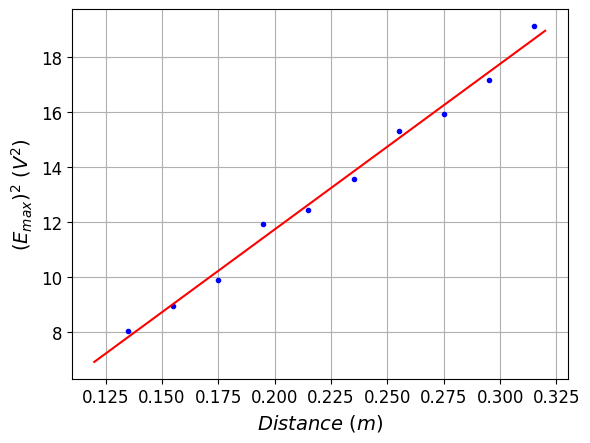

In [14]:
x = np.linspace(0.12, 0.32, 100)
y = emf_max_v_dist(x, slope, intercept)

plt.plot(distance,voltage_peak_sq, 'b.')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$Distance$ $(m)$', fontsize=14)
plt.ylabel('$(E_{max})^2$ $(V^2)$', fontsize=14)
# plt.title('Induced EMF^2 vs position plot', fontsize=18)
plt.grid(1)
plt.plot(x,y, 'r-')
plt.show()

---

### $ EMF_{max} $ vs velocity 

For each of the peak locations, read the upper point in an array and plot the emf vs velocity.

Using equation (as mentioned in the paper)

$
ε_{max} = ±\frac{24}{25\sqrt{5}}μ_0mv\frac{N}{R^2}
\\and
\\2gS = v^2- u^2
$

the dipole moment $ m $ is given by, using $N × 2πR = 50m$ for experiment stated in paper

$
m = Slope\ ×\ \frac{5^{\frac{5}{2}}}{24 × 10^{-5}} R^3
$

In [15]:
#fit our values with linear regression 
velocity = g*time_max_volt/1000 #estimated value of velocity

def emf_max_v_vel(vel, slope, intercept):
    return intercept + slope*vel

(slope, intercept), pcov = curve_fit(emf_max_v_vel, velocity, voltage_peak)
std_err = np.sqrt(np.diag(pcov))

print(f"Estimated value of slope: {slope:.3f} ± {std_err[0]:.4f}")
print(f"Estimated value of intercept: {intercept:.3f} ± {std_err[1]:.4f}")

Estimated value of slope: 1.716 ± 0.0555
Estimated value of intercept: 0.655 ± 0.0968


In [16]:
#Thus, calculate dipole moment
R = 12.61/1000 #12.61 mm as stated in the paper
m = slope * (5**2.5)*(R**3)/(24*(10**(-5)))

print(f"Estimated value of dipole moment is {m:.3f} Am^2")

Estimated value of dipole moment is 0.802 Am^2


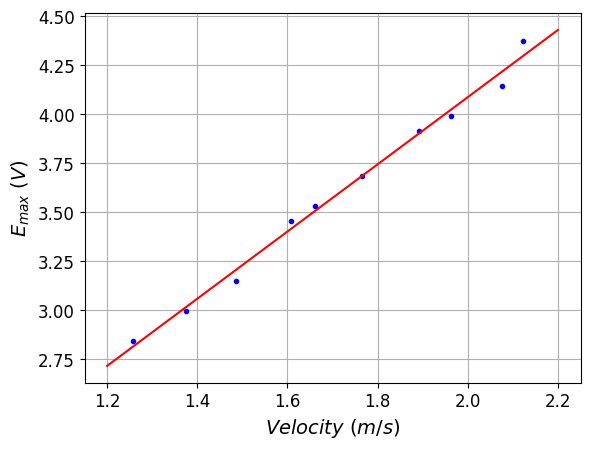

In [19]:
### Plot it
plt.close()
plt.grid(1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$Velocity$ $(m/s)$', fontsize=14)
plt.ylabel('$E_{max}$ $(V)$', fontsize=14)
# plt.title('Calibration curve ')
plt.plot(velocity, voltage_peak, 'b.')

x = np.linspace(1.2, 2.2, 100)
y = emf_max_v_vel(x, slope, intercept)

plt.plot(x, y, 'r')
plt.show()

Verification using Iphone readings

Magnetic field strength, $ B $ vs 1/Distance$ ^3 $, 1/$ z^3 $

Reading taken from iPhone, less repeatability

From the paper

$
B_z = \frac{μ_0m}{2πz^3}
\\⇒ B_z = \frac{2\ ×\ 10^{-7}\ ×\ m}{z^3}
\\⇒ m = \frac{Slope}{2\ ×\ 10^{-7}}
$

Thus using Iphone readings

Estimated value of slope: 1.39e-07 ± 2.076e-09
Estimated value of intercept: 6.96e-05 ± 5.439e-06


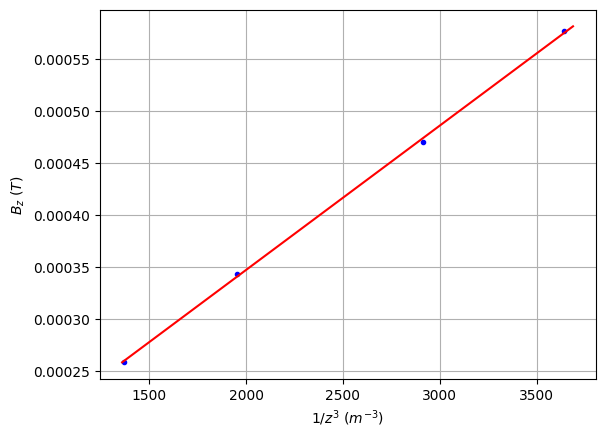

In [26]:
# do a 1st order fit and insert slope and intercept values 
#Verification of Lenz's law using Iphone readings


#Substitute this readings with your own Iphone's data
B = np.array([577, 471, 344, 259]) / 1000000
r = np.array([6.5, 7, 8, 9]) / 100

r = 1/r**3


def B_v_z3(dist3_reciprocal, slope, intercept):
    return slope*dist3_reciprocal + intercept


(slope, intercept), pcov = curve_fit(B_v_z3, r, B)
std_err = np.sqrt(np.diag(pcov))

print(f"Estimated value of slope: {slope:.2e} ± {std_err[0]:.3e}")
print(f"Estimated value of intercept: {intercept:.2e} ± {std_err[1]:.3e}")

x = np.linspace(1360, 3688, 100)
y = B_v_z3(x, slope, intercept)

#plt.plot(r, B, 'r.-')
plt.plot(r, B, 'b.')
# plt.title('B vs 1/(r^3) plot using iPhone readings')
plt.xlabel('$1/z^3$ $(m^{-3})$')
plt.ylabel('$B_z$ $(T)$')
# red_patch = mpatches.Patch(color='red', label='Slope = 1.3881e-07')
plt.grid(1)
# plt.legend(handles=[red_patch])
plt.plot(x,y,'r-')
plt.show()

In [29]:
#Thus compute dipole moment m
m = slope/(2*0.0000001)
print(f"Estimated value of dipole moment is {m:.3f} Am^2")

Estimated value of dipole moment is 0.694 Am^2
